Mounted at /content/drive
[9 7 1 ... 4 0 7]
Decision Tree:  	|	 0.9984450240770465|		 0.8352230506417673±0.007096572314490497|	0.8415245737211635
[[184   0   0   0   0   1   0   1   2  14]
 [  0 178   0   0   0  32   0   7   3   1]
 [  2   1 752   7  30  10  17  27  12   4]
 [  0   0   7   8   0   0   1   0   2   0]
 [  1   1  38   0 184   2   4   6   2   2]
 [  0  28   5   0   3 618   9  23  14   1]
 [  1   5  21   0   4   7 525  54  41   2]
 [  1   5  31   0   2  39  47 805  60   6]
 [  0   4  11   0   1  10  43  51 626   2]
 [  8   0   4   0   0   2   3   4   1 315]]


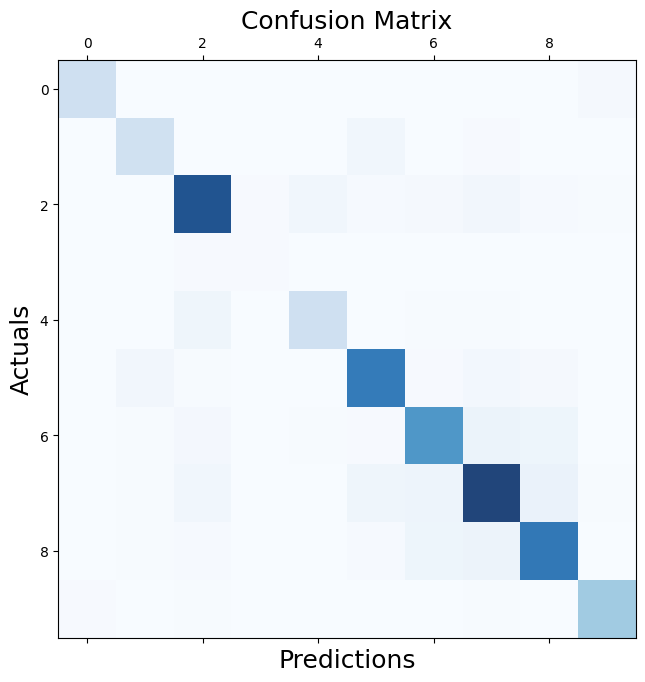

Random Forest	|	 0.9984450240770465|		 0.8703353350747±0.004356318443989876|	0.8722166499498496
[[186   0   0   0   0   0   0   3   1  12]
 [  0 180   0   0   0  34   0   6   1   0]
 [  0   1 768   3  18  11  14  33  14   0]
 [  0   0   6   9   0   0   1   1   1   0]
 [  0   1  40   0 184   1   2   5   5   2]
 [  0   4   4   0   0 652   2  33   6   0]
 [  0   1  14   0   1   9 533  61  40   1]
 [  0   4  17   0   1  30  23 875  45   1]
 [  0   1   6   0   0   8  38  53 642   0]
 [  4   0   4   0   0   2   2   5   1 319]]


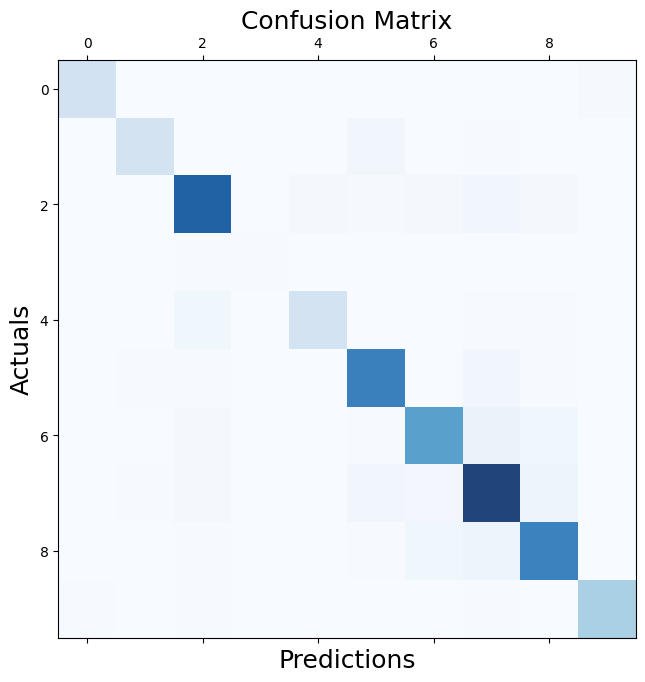

1-NN Classifier	|	 1.0|		 0.8202750966720075±0.005693914994303021|	0.8224674022066198
[[177   2   5   0   0   3   0   2   3  10]
 [  1 167   1   0   0  41   0   7   4   0]
 [  3   3 715  15  47   9  24  23  18   5]
 [  0   0  11   5   0   1   0   0   1   0]
 [  0   2  56   0 169   2   0   5   4   2]
 [  0  23   8   0   3 616  10  28  13   0]
 [  0   4  31   0   1   5 515  55  47   2]
 [  2   4  32   0   9  26  48 817  55   3]
 [  1   2  11   0   3  14  49  59 608   1]
 [  8   0   7   0   1   4   3   3   0 311]]


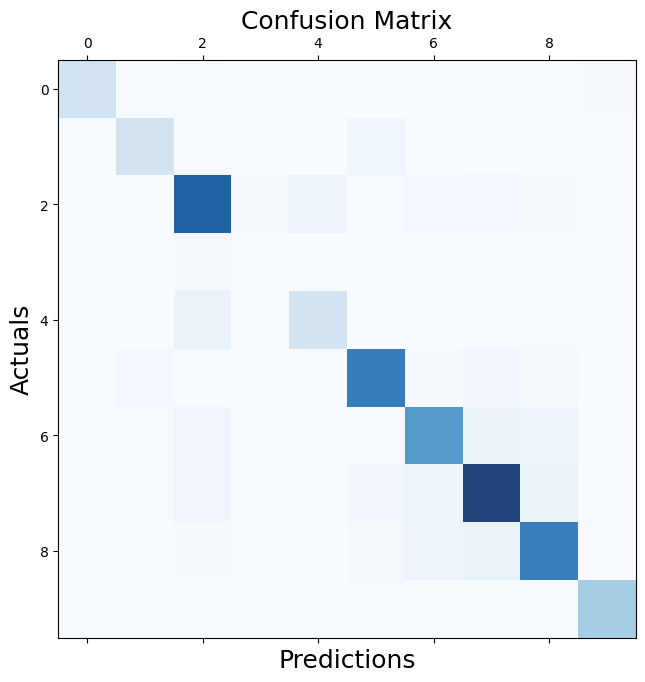

In [4]:
import numpy as np
import sys
np.set_printoptions(threshold=100)


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from google.colab import drive

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.neural_network import MLPClassifier

def print_tree(clf, X_test):
  node_indicator = clf.decision_path(X_test)
  leaf_id = clf.apply(X_test)
  feature = clf.tree_.feature
  threshold = clf.tree_.threshold

  sample_id = 0
  # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
  node_index = node_indicator.indices[
      node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
  ]

  print("Rules used to predict sample {id}:\n".format(id=sample_id))
  for node_id in node_index:
      # continue to the next node if it is a leaf node
      if leaf_id[sample_id] == node_id:
          continue

      # check if value of the split feature for sample 0 is below threshold
      if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print(
          "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature=feature[node_id],
              value=X_test[sample_id, feature[node_id]],
              inequality=threshold_sign,
              threshold=threshold[node_id],
          )
      )

# File input
def read_in_data():
    # path = '/content/drive/My Drive/Colab Notebooks/cosmic_sleuth/data/all_data.txt'
    # path = '/content/drive/My Drive/Colab Notebooks/cosmic_sleuth/data/four_sources.txt'
    # path = '/content/drive/My Drive/Colab Notebooks/cosmic_sleuth/data/four_sources_plus_background.txt'
    path = '/content/drive/My Drive/Colab Notebooks/cosmic_sleuth/data/3FHL_10.txt'

    drive.mount('/content/drive')
    with open(path, 'r') as f:
      temp = np.genfromtxt(f,delimiter=' ', dtype= None)

    #label_size = 3
    # label_size = 1
    
    X = np.array([[a, b, c, d, e, f] for (a, b, c, d, e, f, g) in temp])
    y = np.array([g for (a, b, c, d, e, f, g) in temp])
    # X = temp[:, :-1]
    # y = temp[:, -1]

    return X, y

# Find all unique x,y,x coordinates, assign them a label
def enumerate_unique_labels(y):
    y_options = np.unique(y, axis=0)
    # Convert x,y,z coordinate into an enumerated label
    print(y_options)
    print(np.linalg.norm(y_options[0]))
    print(np.linalg.norm(y_options[1]))
    print(np.linalg.norm(y_options[2]))
    print(np.linalg.norm(y_options[3]))
    y_labels = np.array([np.where(y_options == yi)[0][0] for yi in y])
    return y_labels

def eval_classifier(clf, X_train, X_test, y_train, y_test):
    clf = clf.fit(X_train, y_train)

    print('|\t', clf.score(X_train, y_train), end="|\t")
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print('\t', str(scores.mean()) + '±' + str(scores.std()), end="|\t")
    print(clf.score(X_test, y_test))

    conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    print(conf_matrix)

    plot_confusion_matrix(conf_matrix)

    return clf

def mlp():
    # Create the model
    model = Sequential()
    model.add(Dense(100, input_dim = 6, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def eval_mlp(model, X_train, X_test, y_train, y_test):
    # Convert target classes to categorical ones
    Y_train = to_categorical(y_train)
    Y_test = to_categorical(y_test)

    model.fit(X_train, Y_train, epochs=100, batch_size=200, verbose=1)
    # Test the model after training
    test_results = model.evaluate(X_test, Y_test, verbose=1)
    print(f'Mulilayer Perceptron results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')
    
def eval_Linregression(X_train, X_test, y_train, y_test):
    possibleys = [0, 1, 2, 3]
    clf = LinearRegression().fit(X_train, y_train)
    yhat = clf.predict(X_test)
    yclass = yhat
    for i in range(yhat.shape[0]): 
      yclass[i] = np.argmin(np.linalg.norm(possibleys - yhat[i]))
    score = sum([y1 == y2 for (y1, y2) in zip(yclass, y_test)])
    score = 1.0 * score / y_test.shape[0]

    print('\tLinearRegression Score\t ', score)
    return clf

def plot_confusion_matrix(conf_matrix):
  # Print the confusion matrix using Matplotlib
  #
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.9)
  # for i in range(conf_matrix.shape[0]):
  #     for j in range(conf_matrix.shape[1]):
  #         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
  
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

def tree_forest_pruning(X_train, X_test, y_train, y_test):
  clf = DecisionTreeClassifier(random_state=0)
  path = clf.cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities

  fig, ax = plt.subplots()
  ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
  ax.set_xlabel("effective alpha")
  ax.set_ylabel("total impurity of leaves")
  ax.set_title("Total Impurity vs effective alpha for training set")
  plt.xscale('log')

  clfs = []
  for ccp_alpha in ccp_alphas:
      clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
      clf.fit(X_train, y_train)
      clfs.append(clf)
  print(
      "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
          clfs[-1].tree_.node_count, ccp_alphas[-1]
      )
  )

  clfs = clfs[:-1]
  ccp_alphas = ccp_alphas[:-1]

  node_counts = [clf.tree_.node_count for clf in clfs]
  depth = [clf.tree_.max_depth for clf in clfs]
  fig, ax = plt.subplots(2, 1)
  ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
  ax[0].set_xlabel("alpha")
  ax[0].set_ylabel("number of nodes")
  ax[0].set_title("Number of nodes vs alpha")
  ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
  ax[1].set_xlabel("alpha")
  ax[1].set_ylabel("depth of tree")
  ax[1].set_title("Depth vs alpha")
  plt.xscale('log')
  fig.tight_layout()

  train_scores = [clf.score(X_train, y_train) for clf in clfs]
  test_scores = [clf.score(X_test, y_test) for clf in clfs]

  fig, ax = plt.subplots()
  ax.set_xlabel("alpha")
  ax.set_ylabel("accuracy")
  ax.set_title("Accuracy vs alpha for training and testing sets")
  ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
  ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
  plt.xscale('log')
  ax.legend()
  plt.show()


def main():
    X, y = read_in_data()
    # y_labels = enumerate_unique_labels(y)
    # print(np.unique(y_labels))
    y_options = np.unique(y, axis=0)
    y_labels = np.array([np.where(y_options == yi)[0][0] for yi in y])
    print(y_labels)

    # U, S, Vh = np.linalg.svd(X - X.mean(axis=0))

    # X_momentum = ((X - X.mean(axis=0))[:, 1:5])
    # print(X_momentum.shape)
    # U, S, Vh = np.linalg.svd(X_momentum)

    # plt.plot(range(len(S)), S)
    # plt.show()

    # print(U.shape, S.shape, Vh.shape)

    # X_train, X_test, y_train, y_test = train_test_split(U[:, :6], y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(X - X.mean(axis=0), y_labels, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(X_momentum, y_labels, test_size=0.2)
    # X_train, X_test, y_train, y_test = train_test_split(U[:, :6], y_labels, test_size=0.2)

    # tree_forest_pruning(X_train, X_test, y_train, y_test)

    # Evaluate many different classifiers
    print('Decision Tree:  ', end='\t')
    clf = eval_classifier(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
    #plt.figure(figsize=(20,20))  # set plot size (denoted in inches)
    # tree.plot_tree(clf, fontsize=10)
    # plt.show()

    print('Random Forest', end='\t')
    eval_classifier(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)

    # print('LightGBM', end='\t')
    # eval_classifier(LGBMClassifier(objective='multiclass'), X_train, X_test, y_train, y_test)

    print('1-NN Classifier', end='\t')
    eval_classifier(KNeighborsClassifier(n_neighbors=1), X_train, X_test, y_train, y_test)
    # print('3-NN Classifier', end='\t')
    # eval_classifier(KNeighborsClassifier(n_neighbors=3), X_train, X_test, y_train, y_test)
    # print('10-NN Classifier', end='\t') 
    # eval_classifier(KNeighborsClassifier(n_neighbors=10), X_train, X_test, y_train, y_test)
    # print('GaussianNB Class.', end='\t')
    # eval_classifier(GaussianNB(), X_train, X_test, y_train, y_test)
    # print('LinearRegression:', end='\t')
    # eval_classifier(LinearRegression(), X_train, X_test, y_train, y_test)
    # print('LinearRegression:', end='\t')
    # eval_Linregression(X_train, X_test, y_train, y_test)
    # print('LogisticRegression:', end='\t')
    # eval_classifier(LogisticRegression(), X_train, X_test, y_train, y_test)
    # print('Perceptron Class.:', end='\t')
    # eval_classifier(Perceptron(), X_train, X_test, y_train, y_test)

    # print('MLP Class.', end='\t')
    # eval_classifier(MLPClassifier(max_iter=300), X_train, X_test, y_train, y_test)

    # model = mlp()
    # print(model.summary())
    # print(X_train.shape)

    # eval_mlp(model, X_train, X_test, y_train, y_test)

main()


# 10 sources, Decision Tree pruning

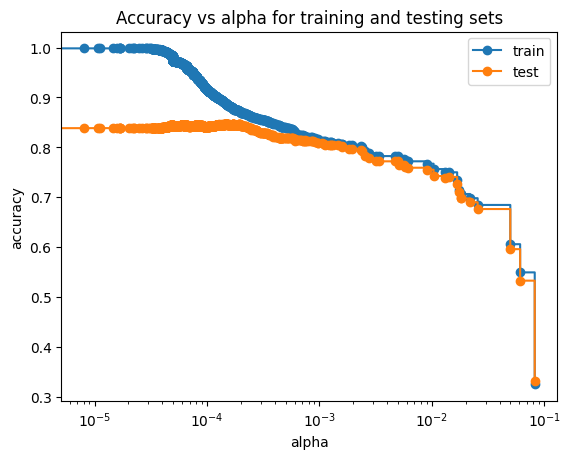
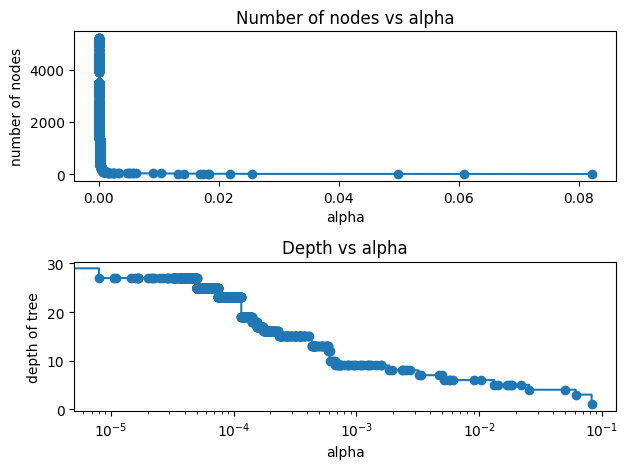

# **four_sources.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 1.0|		 0.9804826862539349±0.004318807057136782|	0.9844733529164919
Random Forest	|	 0.9998950682056663|		 0.983735571878279±0.003912141003632144|	0.9895090222408729
LightGBM	|	 0.9997901364113326|		 0.9844700944386148±0.002451903766117085|	0.9911875786823332
1-NN Classifier	|	 1.0|		 0.9859391395592864±0.002447408979998028|	0.9945446915652539
3-NN Classifier	|	 0.9920251836306401|		 0.975865687303253±0.003954132986656171|	0.9874108266890474
10-NN Classifier	|	 0.9706190975865687|		 0.9600209863588669±0.003172343432913114|	0.9723038187159043
GaussianNB Class.	|	 0.9456453305351522|		 0.9448058761804827±0.005911675139980395|	0.9580360889634914
 MLP (6,20,20,4) | 0.9614 |  | 0.9613931775093079

# **four_sources_plus_background.txt**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 1.0|		 0.9663991355932453±0.000905173151957237|	0.9726516052318668
Random Forest	|	 1.0|		 0.9693729660620111±0.0025304874816804482|	0.974633372968688
LightGBM	|	 0.9981167608286252|		 0.9703639480668038±0.0011849443463421033|	0.9702734839476813
1-NN Classifier	|	 1.0|		 0.9663990373205357±0.003381417144587322|	0.9706698374950455
3-NN Classifier	|	 0.9810684904351273|		 0.9569832833207135±0.003302845333484855|	0.9571938168846611
10-NN Classifier	|	 0.9530181385667559|		 0.9386469715053364±0.00526694041925624|	0.9338089575901705
GaussianNB Class.	|	 0.8929527207850134|		 0.8921597540823711±0.002208306231877971|	0.8910027744748316
MLP Class. |	 0.943899296263257 |	 |	0.9437177962742767

# **3FHL_5.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9964028776978417|		 0.8747544343439202±0.0046449360112625696|	0.8751633986928105
Random Forest	|	 0.9964028776978417|		 0.9110519241765935±0.003801777774599494|	0.9065359477124183
LightGBM	|	 0.9911706998037934|		 0.9048405025678846±0.004265836574260112|	0.9098039215686274
1-NN Classifier	|	 0.9964028776978417|		 0.8873442835842432±0.004674669897159197|	0.8895424836601307
3-NN Classifier	|	 0.9442446043165468|		 0.8906142615127273±0.006179878969753594|	0.8960784313725491
10-NN Classifier	|	 0.9099084368868542|		 0.892575179431271±0.006895739061991336|	0.8954248366013072
GaussianNB Class.	|	 0.7691301504251145|		 0.7683121436091471±0.009242088383747741|	0.7686274509803922

 # Undid only momentum
# **3FHL_5.txt**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 0.9960758665794637|		 0.86805041177005±0.003318173085304933|	0.8633986928104576
Random Forest	|	 0.9960758665794637|		 0.9043475007882684±0.007654769604514996|	0.903921568627451
LightGBM	|	 0.9905166775670373|		 0.901078992512786±0.004075265670573715|	0.9006535947712418
1-NN Classifier	|	 0.9977109221713538|		 0.8808032588887287±0.005024194944366488|	0.8823529411764706
3-NN Classifier	|	 0.9408109875735775|		 0.8870172189889856±0.0026245689209928144|	0.8934640522875817
10-NN Classifier	|	 0.908436886854153|		 0.8919227871033941±0.005973434844961008|	0.9032679738562092
GaussianNB Class.	|	 0.7815565729234794|		 0.7761840058999888±0.07102499949551894|	0.7986928104575164

# Undid SVD, only momentum
# **3FHL_5.txt**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 0.9962393721386528|		 0.9015682533574891±0.005677606600069327|	0.9058823529411765
Random Forest	|	 0.9962393721386528|		 0.9221697155286208±0.006188981875786087|	0.9281045751633987
LightGBM	|	 0.9898626553302813|		 0.9195526643472871±0.008239395783392334|	0.9254901960784314
1-NN Classifier	|	 0.9962393721386528|		 0.8616743890251657±0.004776056010423414|	0.8620915032679739
3-NN Classifier	|	 0.9288750817527796|		 0.8507182595033107±0.00622348650571968|	0.8581699346405228
10-NN Classifier	|	 0.8492478744277305|		 0.7985598736632837±0.004431547086633201|	0.8150326797385621
GaussianNB Class.	|	 0.5716154349247874|		 0.5722696519327273±0.0014351327096097496|	0.561437908496732

# **3FHL_10.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9987459871589085|		 0.8345707174193763±0.0042958229539789864|	0.850752256770311
Random Forest	|	 0.9986958266452648|		 0.8670244115843897±0.003892377943687389|	0.8764292878635908
LightGBM	|	 0.9595204654895666|		 0.863714142175712±0.005896438858644236|	0.8690070210631896
1-NN Classifier	|	 0.9987459871589085|		 0.8175163941787741±0.006764437656517492|	0.827482447342026
3-NN Classifier	|	 0.8994783306581059|		 0.8028194188786575±0.006000501045128934|	0.8190571715145436
10-NN Classifier	|	 0.820024077046549|		 0.7584271122874517±0.005484861110707338|	0.7789368104312939
GaussianNB Class.	|	 0.23645666131621187|		 0.2364568372788292±0.0044434263471306015|	0.23029087261785355
MLP (6, 20, 20, 10) | 0.7873620986938477

# **Four Sources**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 1.0|		 0.9804826862539349±0.004318807057136782|	0.9844733529164919
Random Forest	|	 0.9998950682056663|		 0.983735571878279±0.003912141003632144|	0.9895090222408729
LightGBM	|	 0.9997901364113326|		 0.9844700944386148±0.002451903766117085|	0.9911875786823332
1-NN Classifier	|	 1.0|		 0.9859391395592864±0.002447408979998028|	0.9945446915652539
3-NN Classifier	|	 0.9920251836306401|		 0.975865687303253±0.003954132986656171|	0.9874108266890474
10-NN Classifier	|	 0.9706190975865687|		 0.9600209863588669±0.003172343432913114|	0.9723038187159043
GaussianNB Class.	|	 0.9456453305351522|		 0.9448058761804827±0.005911675139980395|	0.9580360889634914
 MLP (6,20,20,4) | 0.9614 |  | 0.9613931775093079

# **Four Sources + Background**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 1.0|		 0.9663991355932453±0.000905173151957237|	0.9726516052318668
Random Forest	|	 1.0|		 0.9693729660620111±0.0025304874816804482|	0.974633372968688
LightGBM	|	 0.9981167608286252|		 0.9703639480668038±0.0011849443463421033|	0.9702734839476813
1-NN Classifier	|	 1.0|		 0.9663990373205357±0.003381417144587322|	0.9706698374950455
3-NN Classifier	|	 0.9810684904351273|		 0.9569832833207135±0.003302845333484855|	0.9571938168846611
10-NN Classifier	|	 0.9530181385667559|		 0.9386469715053364±0.00526694041925624|	0.9338089575901705
GaussianNB Class.	|	 0.8929527207850134|		 0.8921597540823711±0.002208306231877971|	0.8910027744748316
MLP (6,20,20,4) |	 0.943899296263257 |	 |	0.9437177962742767

# **four_sources.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 1.0|		 0.9804826862539349±0.004318807057136782|	0.9844733529164919
Confusion Matrix:
[[312   0   0   4]
 [  1 868   0   8]
 [  0   0 680   0]
 [  8  16   0 486]]
Random Forest	|	 0.9998950682056663|		 0.983735571878279±0.003912141003632144|	0.9895090222408729
Confusion Matrix:
[[307   1   0   8]
 [  0 870   0   7]
 [  0   0 680   0]
 [  1   8   0 501]]
LightGBM	|	 0.9997901364113326|		 0.9844700944386148±0.002451903766117085|	0.9911875786823332
Confusion Matrix:
[[313   0   0   3]
 [  0 867   0  10]
 [  0   0 680   0]
 [  1   7   0 502]]
1-NN Classifier	|	 1.0|		 0.9859391395592864±0.002447408979998028|	0.9945446915652539
Confusion Matrix:
[[316   0   0   0]
 [  0 872   0   5]
 [  0   0 680   0]
 [  2   6   0 502]]
3-NN Classifier	|	 0.9920251836306401|		 0.975865687303253±0.003954132986656171|	0.9874108266890474
Confusion Matrix:
[[309   2   0   5]
 [  1 873   0   3]
 [  0   0 680   0]
 [  3  16   0 491]]
10-NN Classifier	|	 0.9706190975865687|		 0.9600209863588669±0.003172343432913114|	0.9723038187159043
Confusion Matrix:
[[299   1   0  16]
 [  0 855   0  22]
 [  0   0 680   0]
 [  3  24   0 483]]
GaussianNB Class.	|	 0.9456453305351522|		 0.9448058761804827±0.005911675139980395|	0.9580360889634914
Confusion Matrix:
[[301   0   0  15]
 [  1 835   0  41]
 [  0   9 671   0]
 [ 16  18   0 476]]
 MLP (6,20,20,4) | 0.9614 |  | 0.9613931775093079

# **four_sources_plus_background.txt**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 1.0|		 0.9663991355932453±0.000905173151957237|	0.9726516052318668
[[280   1   0  13   1]
 [  2 882   0  17   1]
 [  1   0 618   0   0]
 [  3  15   0 540   1]
 [  3   2   5   4 134]]
Random Forest	|	 1.0|		 0.9693729660620111±0.0025304874816804482|	0.974633372968688
[[282   2   0  11   0]
 [  1 882   0  19   0]
 [  0   0 619   0   0]
 [  2  14   0 542   1]
 [  3   2   5   4 134]]
LightGBM	|	 0.9981167608286252|		 0.9703639480668038±0.0011849443463421033|	0.9702734839476813
[[282   2   0  11   0]
 [  0 875   0  27   0]
 [  0   0 619   0   0]
 [  5  15   0 539   0]
 [  3   2   6   4 133]]
1-NN Classifier	|	 1.0|		 0.9663990373205357±0.003381417144587322|	0.9706698374950455
[[277   0   0  17   1]
 [  1 886   0  15   0]
 [  0   0 619   0   0]
 [  6  15   0 537   1]
 [  2   3   8   5 130]]
3-NN Classifier	|	 0.9810684904351273|		 0.9569832833207135±0.003302845333484855|	0.9571938168846611
[[271   2   0  22   0]
 [  2 872   0  28   0]
 [  0   0 619   0   0]
 [ 12  16   0 529   2]
 [  5   5  10   4 124]]
10-NN Classifier	|	 0.9530181385667559|		 0.9386469715053364±0.00526694041925624|	0.9338089575901705
[[266   4   0  24   1]
 [  0 860   2  39   1]
 [  0   0 619   0   0]
 [ 15  41   1 500   2]
 [  9   8  15   5 111]]
GaussianNB Class.	|	 0.8929527207850134|		 0.8921597540823711±0.002208306231877971|	0.8910027744748316
[[280   0   0  14   1]
 [ 17 807   0  75   3]
 [  0   0 599   1  19]
 [ 83  25   0 448   3]
 [  4   9  16   5 114]]
MLP Class. |	 0.943899296263257 |	 0.9422129441865058±0.007725076363676513|	0.9437177962742767

# **3FHL_5.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9964028776978417|		 0.8747544343439202±0.0046449360112625696|	0.8751633986928105
[[180   0   2   0   0]
 [  1 231   7   0   2]
 [  3   7 735  15  72]
 [  1   0  14   5   0]
 [  3   3  61   0 188]]
Random Forest	|	 0.9964028776978417|		 0.9110519241765935±0.003801777774599494|	0.9065359477124183
[[180   0   2   0   0]
 [  1 232   5   0   3]
 [  0   7 787   2  36]
 [  1   0  17   2   0]
 [  0   2  67   0 186]]
LightGBM	|	 0.9911706998037934|		 0.9048405025678846±0.004265836574260112|	0.9098039215686274
[[179   0   3   0   0]
 [  0 232   7   0   2]
 [  0   5 788   3  36]
 [  0   0  15   4   1]
 [  1   2  63   0 189]]
1-NN Classifier	|	 0.9964028776978417|		 0.8873442835842432±0.004674669897159197|	0.8895424836601307
[[181   1   0   0   0]
 [  2 227  10   0   2]
 [  2  14 768   7  41]
 [  1   0  16   3   0]
 [  1   6  65   1 182]]
3-NN Classifier	|	 0.9442446043165468|		 0.8906142615127273±0.006179878969753594|	0.8960784313725491
[[180   0   2   0   0]
 [  3 228   8   0   2]
 [  3   8 787   2  32]
 [  1   0  17   2   0]
 [  1   4  76   0 174]]
10-NN Classifier	|	 0.9099084368868542|		 0.892575179431271±0.006895739061991336|	0.8954248366013072
[[179   1   2   0   0]
 [  2 230   9   0   0]
 [  1   9 802   0  20]
 [  1   0  19   0   0]
 [  0   2  94   0 159]]
GaussianNB Class.	|	 0.7691301504251145|		 0.7683121436091471±0.009242088383747741|	0.7686274509803922
[[179   3   0   0   0]
 [  9 228   4   0   0]
 [ 22  41 769   0   0]
 [  3   1  16   0   0]
 [  9  10 236   0   0]]

 # Undid only momentum
# **3FHL_5.txt**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 0.9960758665794637|		 0.86805041177005±0.003318173085304933|	0.8633986928104576
[[198   0   5   0   2]
 [  1 198   9   0   5]
 [  6   8 758  11  71]
 [  1   0  15   8   2]
 [  1   2  69   1 159]]
Random Forest	|	 0.9960758665794637|		 0.9043475007882684±0.007654769604514996|	0.903921568627451
[[197   0   8   0   0]
 [  0 204   8   0   1]
 [  2   2 820   5  25]
 [  0   0  20   6   0]
 [  1   2  73   0 156]]
LightGBM	|	 0.9905166775670373|		 0.901078992512786±0.004075265670573715|	0.9006535947712418
[[197   0   7   0   1]
 [  0 201  12   0   0]
 [  1   1 814   6  32]
 [  0   0  19   7   0]
 [  1   4  68   0 159]]
1-NN Classifier	|	 0.9977109221713538|		 0.8808032588887287±0.005024194944366488|	0.8823529411764706
[[198   0   7   0   0]
 [  1 199  12   0   1]
 [  3   6 781  16  48]
 [  1   0  19   5   1]
 [  1   2  62   0 167]]
3-NN Classifier	|	 0.9408109875735775|		 0.8870172189889856±0.0026245689209928144|	0.8934640522875817
[[197   0   8   0   0]
 [  2 203   7   0   1]
 [  6   8 813   6  21]
 [  1   0  20   5   0]
 [  1   4  78   0 149]]
10-NN Classifier	|	 0.908436886854153|		 0.8919227871033941±0.005973434844961008|	0.9032679738562092
[[195   1   9   0   0]
 [  2 205   6   0   0]
 [  2   4 835   0  13]
 [  0   0  25   1   0]
 [  0   1  85   0 146]]
GaussianNB Class.	|	 0.7815565729234794|		 0.7761840058999888±0.07102499949551894|	0.7986928104575164
[[192   5   8   0   0]
 [  5 202   6   0   0]
 [  3  46 699   0 106]
 [  0   0  20   0   6]
 [  2   8  93   0 129]]

# Undid SVD, only momentum
# **3FHL_5.txt**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 0.9962393721386528|		 0.9015682533574891±0.005677606600069327|	0.9058823529411765
[[193   2   4   0   0]
 [  0 211   5   0   2]
 [  4   8 780  10  46]
 [  0   0   9  12   0]
 [  1   2  51   0 190]]
Random Forest	|	 0.9962393721386528|		 0.9221697155286208±0.006188981875786087|	0.9281045751633987
[[195   0   3   1   0]
 [  0 215   3   0   0]
 [  2   9 814   1  22]
 [  0   0  12   9   0]
 [  0   1  56   0 187]]
LightGBM	|	 0.9898626553302813|		 0.9195526643472871±0.008239395783392334|	0.9254901960784314
[[192   0   6   0   1]
 [  0 213   5   0   0]
 [  2   5 810   1  30]
 [  0   0  10  11   0]
 [  0   0  54   0 190]]
1-NN Classifier	|	 0.9962393721386528|		 0.8616743890251657±0.004776056010423414|	0.8620915032679739
[[178   4  15   0   2]
 [  4 201  10   1   2]
 [  7  11 761   9  60]
 [  0   0  14   7   0]
 [  2   3  66   1 172]]
3-NN Classifier	|	 0.9288750817527796|		 0.8507182595033107±0.00622348650571968|	0.8581699346405228
[[177   2  17   0   3]
 [ 10 189  13   0   6]
 [  9  18 778   7  36]
 [  0   0  16   5   0]
 [  1   2  77   0 164]]
10-NN Classifier	|	 0.8492478744277305|		 0.7985598736632837±0.004431547086633201|	0.8150326797385621
[[138   7  50   0   4]
 [ 11 175  31   0   1]
 [ 11  23 797   0  17]
 [  0   0  21   0   0]
 [  2   1 104   0 137]]
GaussianNB Class.	|	 0.5716154349247874|		 0.5722696519327273±0.0014351327096097496|	0.561437908496732
[[ 13   0 186   0   0]
 [  8   0 210   0   0]
 [  2   0 846   0   0]
 [  0   0  21   0   0]
 [  0   0 244   0   0]]

# **3FHL_10.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9987459871589085|		 0.8345707174193763±0.0042958229539789864|	0.850752256770311
[[171   0   1   0   0   1   0   0   1   8]
 [  0 186   1   0   0  20   1   7   3   0]
 [  0   5 708   4  44  12  13  27  10   6]
 [  0   0   4  11   0   0   0   0   0   0]
 [  0   1  39   0 171   2   3  10   3   0]
 [  1  20   8   0   1 676   5  21   6   0]
 [  0   4  28   5   2   6 579  41  39   2]
 [  2   3  26   1   4  18  53 800  64   1]
 [  0   4  18   0   4   9  37  60 600   2]
 [ 15   0   1   0   1   1   1   2   2 339]]
Random Forest	|	 0.9986958266452648|		 0.8670244115843897±0.003892377943687389|	0.8764292878635908
[[172   0   1   0   0   0   0   2   0   7]
 [  0 186   0   0   0  25   0   5   2   0]
 [  2   0 735   1  27   7  10  28  16   3]
 [  0   0   5  10   0   0   0   0   0   0]
 [  0   1  38   0 176   2   2   9   1   0]
 [  0  13   5   0   0 689   2  21   8   0]
 [  0   1  15   0   2   6 597  51  34   0]
 [  2   2  14   0   1  22  31 845  55   0]
 [  0   2   6   0   1  10  41  52 622   0]
 [ 18   0   2   0   1   2   0   2   0 337]]
LightGBM	|	 0.9595204654895666|		 0.863714142175712±0.005896438858644236|	0.8690070210631896
[[168   0   1   0   0   0   0   2   0  11]
 [  0 181   0   0   0  28   0   6   3   0]
 [  0   0 713   1  36   8  19  31  15   6]
 [  0   0   7   8   0   0   0   0   0   0]
 [  0   0  39   0 177   2   0   9   2   0]
 [  0   9   3   0   0 688   2  30   5   1]
 [  0   0  19   0   1   6 584  57  39   0]
 [  1   3  17   0   2  22  23 853  50   1]
 [  0   4   1   0   1  12  46  49 621   0]
 [ 16   0   2   0   0   0   0   4   1 339]]
1-NN Classifier	|	 0.9987459871589085|		 0.8175163941787741±0.006764437656517492|	0.827482447342026
[[163   2   2   0   0   1   0   2   2  10]
 [  3 171   1   0   1  30   2   9   1   0]
 [  1   3 685   7  52   8  23  23  21   6]
 [  0   0   9   5   1   0   0   0   0   0]
 [  1   2  61   1 149   6   1   5   3   0]
 [  0  21   5   0   2 654   9  36  11   0]
 [  1   2  24   1   2   5 561  52  56   2]
 [  3   4  34   2   6  20  45 796  61   1]
 [  1   3   7   2   5  11  57  49 597   2]
 [  6   1   3   0   0   0   2   3   3 344]]
3-NN Classifier	|	 0.8994783306581059|		 0.8028194188786575±0.006000501045128934|	0.8190571715145436
[[160   1   4   0   0   1   1   2   1  12]
 [  5 166   2   0   0  37   0   6   2   0]
 [  6   6 701   1  41   6  24  21  20   3]
 [  0   0  10   4   1   0   0   0   0   0]
 [  0   1  65   1 144   6   2   6   4   0]
 [  1  22  11   0   1 660   4  30   9   0]
 [  3   6  36   0  10   7 557  48  38   1]
 [  7   5  51   0   9  23  49 777  51   0]
 [  1   4  32   2   2   8  62  43 580   0]
 [ 13   1   9   0   0   0   0   3   2 334]]
10-NN Classifier	|	 0.820024077046549|		 0.7584271122874517±0.005484861110707338|	0.7789368104312939
[[132   0  17   0   0   1   2   3   4  23]
 [  9 134   5   0   0  54   0  11   5   0]
 [ 15   1 664   0  27   9  34  50  29   0]
 [  0   0  15   0   0   0   0   0   0   0]
 [  1   1  82   1 118   3   5  12   5   1]
 [  2   9   6   0   0 655   4  44  17   1]
 [  2   1  46   0   1   8 521  77  50   0]
 [  4   1  26   0   2  29  47 802  61   0]
 [  0   7  18   0   0   8  57  82 560   2]
 [ 19   0  29   0   0   1   5   9   2 297]]
GaussianNB Class.	|	 0.23645666131621187|		 0.2364568372788292±0.0044434263471306015|	0.23029087261785355
[[ 17   0  69   0   0   0   0  96   0   0]
 [ 11   0  96   0   0   0   0 111   0   0]
 [  1   0 404   0   0   0   0 424   0   0]
 [  0   0  10   0   0   0   0   5   0   0]
 [  0   0 139   0   0   0   0  90   0   0]
 [  0   0 342   0   0   0   0 396   0   0]
 [  0   0 301   0   0   0   0 405   0   0]
 [  0   0 245   0   0   0   0 727   0   0]
 [  0   0 280   0   0   0   0 454   0   0]
 [  0   0 205   0   0   0   0 157   0   0]]
MLP (6, 20, 20, 10) | 0.7873620986938477


# **3FHL_15.txt**
clf|train|5-fold cv|test
---|---|---|---
 Decision Tree:  	|	 0.9990943786790866|		 0.8308753982406796±0.005735516167881322|	0.8386804657179819
Random Forest	|	 0.9990943786790866|		 0.8618282372544673±0.005315672437065865|	0.8680465717981889
LightGBM	|	 0.9531987838799405|		 0.8227270544636957±0.0696441968073558|	0.8609314359637775
1-NN Classifier	|	 0.9990943786790866|		 0.8197491965094794±0.00414496751845954|	0.8230271668822768
3-NN Classifier	|	 0.8977294779739957|		 0.8041596235055055±0.005720684845109442|	0.8147477360931435
10-NN Classifier	|	 0.8266382042822951|		 0.7637945267445542±0.007141263007501111|	0.7719275549805951
GaussianNB Class.	|	 0.16003622485283653|		 0.16003619342691294±0.0016061340107454561|	0.16054333764553688


# **3FHL_20.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9994134765052223|		 0.8154030181015607±0.0028896816437084544|	0.8240548587927456
Random Forest	|	 0.9994134765052223|		 0.8417064295891873±0.004175804017381812|	0.8488676351168456
LightGBM	|	 0.9359787046854203|		 0.6770096399243279±0.13414625760272156|	0.840656861860507
1-NN Classifier	|	 0.9994134765052223|		 0.8054320586169285±0.0038632674130424823|	0.8107913019940449
3-NN Classifier	|	 0.8889440321234406|		 0.7916036764210992±0.0034261168937066364|	0.8015880176847424
10-NN Classifier	|	 0.8195989081639559|		 0.7573145697887798±0.003351124845179881|	0.7767752413606425
GaussianNB Class.	|	 0.16630196936542668|		 0.16630196359687108±0.00026892908585192144|	0.16917802039159072


# **3FHL_25.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9995330459770115|		 0.78902658045977±0.0038930054398290015|	0.8016522988505748
Random Forest	|	 0.9995150862068966|		 0.8160201149425287±0.00287827379706404|	0.8242097701149426
LightGBM	|	 0.6091594827586206|		 0.6301724137931034±0.09412298297154886|	0.5894396551724138
1-NN Classifier	|	 0.9995330459770115|		 0.7793283045977011±0.003495748265685891|	0.7897270114942528
3-NN Classifier	|	 0.8717672413793104|		 0.7683189655172413±0.0019284812780956833|	0.7790948275862069
10-NN Classifier	|	 0.8031788793103448|		 0.7364403735632183±0.0016023497143100164|	0.7551724137931034
GaussianNB Class.	|	 0.13320761494252872|		 0.13322557471264368±0.0021254839722278894|	0.1314655172413793


# **3FHL_50.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9996524709316758|		 0.7876696657130097±0.0016652716136653536|	0.7892207482723013
Random Forest	|	 0.9996524709316758|		 0.8142507069882768±0.0021911075144245245|	0.8175391214552387
LightGBM	|	 0.5348670949548708|		 0.5200125083214346±0.015575606089228379|	0.5281992215426166
1-NN Classifier	|	 0.9996524709316758|		 0.7754168123889762±0.0016178434307896734|	0.7769084121058066
3-NN Classifier	|	 0.868405635928548|		 0.7645242498658671±0.0014048472575427422|	0.7693224243387083
10-NN Classifier	|	 0.8026134185937981|		 0.7374269509695184±0.0031106126358851384|	0.747914846294384
GaussianNB Class.	|	 0.0730208219558936|		 0.07290166590774481±0.0005466808696561313|	0.07494638176185558

# **(momentum only) 3FHL_100.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.898344782548633|		 0.6591357154710806±0.0006679982200825617|	0.6761943035113277
Random Forest	|	 0.8983322239943737|		 0.6856154333608013±0.0007395957666451339|	0.6965389059124931
1-NN Classifier	|	 0.8728760345109071|		 0.6437389193510776±0.0017181204728622483|	0.6500226051137791

# **(rigidity+momentum) 3FHL_100.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.999114621924724|		 0.7828625879518384±0.0015547745197433253|	0.7904254784749083
Random Forest	|	 0.999114621924724|		 0.8102716430759058±0.0012136157587198766|	0.8154920379765912
1-NN Classifier	|	 0.999114621924724|		 0.7649227080548278±0.0005385171826622012|	0.7752549354498418

# **(all features) 3FHL_100.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.9991836939731498|		 0.7839426438459256±0.0016492148937452566|	0.7900989601647662
Random Forest	|	 0.9991774146960202|		 0.8193012641722124±0.0025737750610848238|	0.8227005575928066
1-NN Classifier	|	 0.9996106848179638|		 0.7670388188487732±0.0019341230345341796|	0.7750288843120511

# **(rigidity+momentum) 3FHL_100.txt**
clf|train|5-fold cv|test
---|---|---|---
Decision Tree:  	|	 0.999114621924724|		 0.7828625879518384±0.0015547745197433253|	0.7904254784749083
Random Forest	|	 0.999114621924724|		 0.8102716430759058±0.0012136157587198766|	0.8154920379765912
LightGBM	|	 0.4329749959184699|		 0.4452508458364835±0.011528559702857934|	0.4308785854222133
1-NN Classifier	|	 0.999114621924724|		 0.7649227080548278±0.0005385171826622012|	0.7752549354498418
3-NN Classifier	|	 0.8642357491805543|		 0.7531490563375276±0.0006884312333789296|	0.7654845029386648
10-NN Classifier	|	 0.7893616486870032|		 0.7213507984859053±0.000705630479330936|	0.7390616366102376
GaussianNB Class.	|	 0.04646037148203499|		 0.04732064562589731±0.0013500656288492252|	0.04641583362636258


Text(0.5, 1.0, '3FHL Scenario (Test accuracy vs Number of sources)')

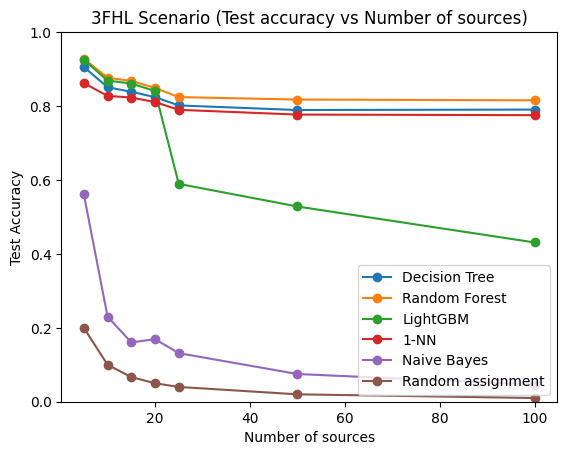

In [16]:
num_sources = [5, 10, 15, 20, 25, 50, 100]
decision_tree = [0.9058823529411765, 0.850752256770311, 0.8386804657179819, 0.8240548587927456, 0.8016522988505748, 0.7892207482723013, 0.7904254784749083]
random_forest = [0.9281045751633987, 0.8764292878635908, 0.8680465717981889, 0.8488676351168456, 0.8242097701149426, 0.8175391214552387, 0.8154920379765912]
lightGBM = [0.9254901960784314, 0.8690070210631896, 0.8609314359637775, 0.840656861860507, 0.5894396551724138, 0.5281992215426166, 0.4308785854222133]
kNN_1 = [0.8620915032679739, 0.827482447342026, 0.8230271668822768, 0.8107913019940449, 0.7897270114942528, 0.7769084121058066, 0.7752549354498418]
naive_bayes = [0.561437908496732, 0.23029087261785355, 0.16054333764553688, 0.16917802039159072, 0.1314655172413793, 0.07494638176185558, 0.04641583362636258]
random = [1/5, 1/10, 1/15, 1/20, 1/25, 1/50, 1/100]


plt.plot(num_sources, decision_tree, marker="o", label='Decision Tree')
plt.plot(num_sources, random_forest, marker="o", label='Random Forest')
plt.plot(num_sources, lightGBM, marker="o", label='LightGBM')
plt.plot(num_sources, kNN_1, marker="o", label='1-NN')
plt.plot(num_sources, naive_bayes, marker="o", label='Naive Bayes')
plt.plot(num_sources, random, marker="o", label='Random assignment')
plt.xlabel("Number of sources")
plt.ylabel("Test Accuracy")
ax = plt.gca()
ax.set_ylim([0, 1])
ax.legend()
ax.set_title('3FHL Scenario (Test accuracy vs Number of sources)')